In [1]:
from typing import cast
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv(retina.filesys.DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df

,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,feature-10,feature-11,feature-12,feature-13,feature-14,feature-15,feature-16,feature-17,feature-18,feature-19,feature-20
0,0.069987,0.207274,-0.529634,-0.074298,0.207834,-0.134538,0.003995,-0.115464,-0.020512,0.015728,-0.042779,-0.055064,-0.038355,0.016665,-0.007752,-0.028955,0.012439,-0.001129,-0.007797,-0.010151
1,0.086153,0.283668,-0.626935,-0.138572,0.101790,-0.195184,-0.029963,-0.072183,-0.082879,0.004617,-0.070901,-0.059785,-0.030072,0.020602,-0.021984,-0.038658,0.007484,-0.001092,-0.012959,-0.023391
2,-0.026549,0.387918,-0.671782,-0.038305,0.129724,-0.188027,-0.022174,-0.099785,-0.119227,0.067609,-0.007397,-0.010925,-0.022512,0.030571,-0.003701,-0.047293,0.031777,-0.005288,-0.009755,-0.028053
3,0.142167,0.455626,-0.640755,-0.026633,0.152358,-0.175852,-0.029910,-0.050276,-0.089160,0.055330,0.016368,-0.032838,-0.038171,-0.028392,0.011447,-0.044402,0.024302,-0.010550,-0.032960,-0.018095
4,0.078328,0.287020,-0.635085,-0.024531,0.168937,-0.158685,-0.000975,-0.065563,-0.131774,0.032022,-0.001033,-0.041685,-0.057882,-0.030421,-0.000314,-0.022522,0.007381,-0.031350,-0.013043,-0.023964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,0.262328,0.799239,-0.469356,0.031247,-0.133681,0.168659,0.020668,-0.025428,0.115192,-0.017586,-0.018082,-0.044645,-0.044972,-0.006590,-0.001869,0.051826,-0.045835,0.003970,0.023287,-0.022545
4126,0.296882,0.781950,-0.373892,0.029026,-0.081238,0.149979,0.029373,0.042767,0.066993,-0.070689,0.009462,-0.015082,-0.024620,0.023297,0.005140,0.030598,-0.039688,-0.004922,-0.003645,0.002411
4127,0.416429,0.786908,-0.317126,0.076410,-0.093916,0.049089,-0.010713,0.052607,0.061790,-0.046928,-0.022366,-0.069785,-0.048383,0.022116,-0.022639,0.039514,-0.029076,0.002833,0.003256,-0.006211
4128,0.382537,0.782316,-0.435671,0.032212,-0.112984,0.023537,-0.017548,0.025625,0.078745,-0.017071,-0.026014,-0.051207,-0.029728,0.020888,-0.016775,0.039465,-0.032497,0.005833,0.006631,-0.010721


In [61]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset = train_dataset.repeat(5).shuffle(100).batch(16)
test_dataset = test_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(20,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [62]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(100, activation="sigmoid"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(500, activation="sigmoid"),
  keras.layers.Dense(6),
  keras.layers.Softmax(),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.005), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

In [63]:
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3099 - loss: 1.7347 - val_accuracy: 0.4475 - val_loss: 1.4359
Epoch 2/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4802 - loss: 1.3589 - val_accuracy: 0.5202 - val_loss: 1.2739
Epoch 3/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5381 - loss: 1.2138 - val_accuracy: 0.5629 - val_loss: 1.1705
Epoch 4/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5772 - loss: 1.1176 - val_accuracy: 0.5882 - val_loss: 1.0875
Epoch 5/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6123 - loss: 1.0183 - val_accuracy: 0.6217 - val_loss: 0.9929
Epoch 6/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6419 - loss: 0.9454 - val_accuracy: 0.6332 - val_loss: 0.9354
Epoch 7/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6703 - loss: 0.8666 - val_accuracy: 0.6632 - val_loss: 0.8545
Epoch 8/20
633/633 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6997 - loss: 0.7895 - val_accuracy: 0.

In [64]:
model.evaluate(test_dataset)

78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8749 - loss: 0.4193


[0.4070563018321991, 0.8635996580123901]

In [67]:
model.save("checkpoint/save1.keras")

C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_24068\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


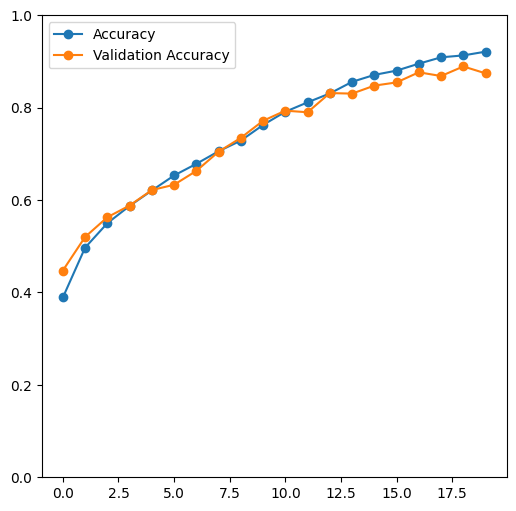

In [66]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()